<a href="https://colab.research.google.com/github/Sooryakiran/CS6886_SysDL/blob/master/assignment_3/Submission/Step%202/step_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 2: ML Flow Experiments

### Hyperparameter tuning

##### Model Hyperparameters tuning

1. Filter sizes for each conv layer (3 and 5)
2. Channel sizes for each conv layers (8, 16, 32)
3. Output size for layer 3 (64, 100)

The best from the above experiment is to be choosen and the next experiment is to be performed


### Install MLflow

In [0]:
!pip install mlflow

### Mount drive for persistence

Click on mount drive from the left pane and check if drive is mounted by running the below codes

In [0]:
!cd 'drive/My Drive/SysDL/Assg 3/' && ls

mlruns	step_1.ipynb  step_2.ipynb


### Load Mlflow libraires and set MLflow logdir

In [0]:
import mlflow
from mlflow import log_metric, log_param, log_artifacts

mlflow.set_tracking_uri("file:///content/drive/My Drive/SysDL/Assg 3/mlruns")
print("MLflow is now set to log in", mlflow.get_tracking_uri())

MLflow is now set to log in file:///content/drive/My Drive/SysDL/Assg 3/mlruns


### Import torch libraries

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

#### Set initial hyperparameters

In [0]:
BATCH_SIZE    = 32
EPOCHS        = 5
LEARNING_RATE = 0.001
MOMENTUM      = 0.9

### Define necessary functions and objects

In [0]:
class NormalizeTransform:
    """
    A torch transform class that normalises the dataset

    """
    
    def __init__(self, mean = 0.5, var = 0.5):
        """
        The class constructor

        @param mean : mean of the output dataset
        @param var  : variance of the output datset

        """

        self.mean = mean
        self.var  = var
    
    def __call__(self, x):
        """
        This function is called when the object is called.

        @param x : input datset
        @returns : normalized dataset

        """

        return (x-self.mean)/(self.var)


def imshow(image):
    """
    A function to print images of size 28x28 from the dataset

    @param image: input torch tensor representing the image

    """

    npimg = image.numpy()
    plt.imshow(np.resize(npimg, (28, 28)), cmap = 'gray')
    plt.show()



class ConvNet(nn.Module):
    """
    The network is defined as a torch module.

    """

    def __init__(self,\
                 conv_layer_1_filter_size,\
                 conv_layer_2_filter_size,\
                 conv_layer_1_channel_size,\
                 conv_layer_2_channel_size,\
                 layer_3_size):
        
        """
        The class constructor.

        """

        super(ConvNet, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels = 1, out_channels = conv_layer_1_channel_size,  kernel_size = conv_layer_1_filter_size)
        self.conv_2 = nn.Conv2d(in_channels = conv_layer_1_channel_size, out_channels = conv_layer_2_channel_size, kernel_size = conv_layer_2_filter_size)
        
        size = 28
        size = size - conv_layer_1_filter_size + 1
        size = size - conv_layer_2_filter_size + 1
        self.fc_1_input_size = conv_layer_2_channel_size*size*size
        self.fc_1   = nn.Linear(self.fc_1_input_size, layer_3_size)
        self.fc_2   = nn.Linear(layer_3_size, 10)

    def forward(self, x):
        """
        The forward pass of the network.

        Layer 1: Convolution 3x3 16 channels with relu
        Layer 2: Convolution 3x3 16 channels with relu
        Layer 3: Fully connected 100 neurons with relu
        Layer 4: Output fully connected layer 10 neurons without activation 

        @param x : Input tensor of size (BATCH_SIZE, 1, 28, 28)
        @return  : Network output tensor of size (BATCH_SIZE, 10)

        """
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = x.view(-1,  self.fc_1_input_size)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x


class initParams:
    """
    An object to initialize the network parameters throgh the method specified

    """

    def __init__(self, method = torch.nn.init.xavier_uniform_):
        """
        The class constructor.

        @param method: the torch.nn.init function to be used to initialize the
                       network parameters

        """

        self.method = method
    
    def __call__(self, layer):
        """
        A function to initialize the network parameters. The weights are initialized
        with given method (default = Xavier uniform) initialization. The biases are 
        initialized with zeros.

        Usage:
            net.apply(init_params)
            where net is an nn.Module or nn.Seqential
        
        @param layer : each layers of the nn.Module/nn.Sequential

        """

        if type(layer) == nn.Linear:
            self.method(layer.weight)
            layer.bias.data.fill_(0.0)

        elif type(layer) == nn.Conv2d:
            self.method(layer.weight)
            layer.bias.data.fill_(0.0)


def accuracy(pred, target):
    """
    A function to calculate accuracy of a prediction.

    @param pred   : Network predictions tensor of size (BATCH_SIZE, num outputs)
    @param target : Target labels of size (BATCh_SIZE)

    Note: @param target is NOT onehot encoded.

    @return       : accuracy of the prediction.

    """

    preds    = torch.argmax(pred, dim = -1).detach().numpy()
    target   = target.detach().numpy()
    corrects = np.mean(np.asarray([preds[i] == target[i] for i in range(preds.shape[0])]))
    return corrects

def test(network, test_loader, criterion, accuracy_fn):
    """
    This function evaluates a model on the test dataset.

    @param network     : Neural network model
    @param test_loader : The dataloader object for the test dataset
    @param criterion   : The loss function
    @param accuracy_fn : The accuracy function

    @return test_loss, test_accuracy 

    """

    loss     = 0.0
    accuracy = 0.0
    batches  = 0

    for i, data in enumerate(test_loader):
        inputs, labels = data
        outputs        = net(inputs)

        loss     += criterion(outputs, labels)
        accuracy += accuracy_fn(outputs, labels)
        batches   = i + 1
    
    return (loss/batches).item(), (accuracy/batches).item()

### Define the dataloaders

In [0]:
transform = transforms.Compose([transforms.ToTensor(), NormalizeTransform()])

train_dataset = torchvision.datasets.FashionMNIST(train = True,
                                  root = '.',
                                  download = True,
                                  transform = transform)

test_dataset = torchvision.datasets.FashionMNIST(train = False,
                                  root = '.',
                                  download = True, 
                                  transform = transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)
test_dataloader  = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2)

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
def train_and_evaluate(network, criterion, optimizer, train_dataloader, test_dataloader, train_till = 90):
    """
    A function which trains the given network till the training accuracy reaches
    the specified value, on the given dataset, using the specified loss function
    and using the given optimzer.

    @param network          : Torch nn.Module or nn.Sequential network object
    @param criterion        : The loss function
    @param optimizer        : The optimizer object
    @param train_dataloader : The dataloader object of the training dataset
    @param test_dataloader  : The dataloader object of the test dataset
    @param train_till       : The training accuracy till which the network has 
                              to be trained
    @return t_acc           : Test accuracy on training till training accuracy 
                              becomes the specified value
    @return training_time   : Time required to reach the specified training 
                              accuracy

    """
    done = False

    start_time = time.time()
    while not done:

        running_loss     = 0.0
        running_accuracy = 0.0

        for i, data in enumerate(train_dataloader):
            if not done:
                inputs, labels = data
                optimizer.zero_grad()

                outputs = net(inputs)
                loss    = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                running_loss     += loss.item()
                running_accuracy += accuracy(outputs, labels)

                PRINT_EVERY = 256
                if i % PRINT_EVERY == PRINT_EVERY - 1:    
                    print('[BATCH: %5d]\t Loss: %.3f\t Accuracy: %.3f %% ' %
                        (i + 1, running_loss / PRINT_EVERY, running_accuracy*100 / PRINT_EVERY))
                    
                    t_loss, t_acc = test(net, test_dataloader, criterion, accuracy)
                    print("Test Loss: %f\t Test Accuracy: %f %%" %(t_loss, t_acc*100))

                    done             = running_accuracy*100/PRINT_EVERY > train_till
                    running_accuracy = 0.0
                    running_loss     = 0.0

    return t_acc, time.time() - start_time

### Do a simple test run

In [0]:
net         = ConvNet(3, 3, 8, 8, 64)
init_params = initParams()
net.apply(init_params)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = LEARNING_RATE, momentum = MOMENTUM)

print(train_and_evaluate(network = net,\
                         criterion=criterion,\
                         optimizer=optimizer,\
                         train_dataloader = train_dataloader,\
                         test_dataloader = test_dataloader,\
                         train_till=90))

### Define the search space

In [0]:
conv_layer_1_filter_sizes = [3, 5]
conv_layer_2_filter_sizes = [3, 5]
conv_layer_1_channel_sizes = [8, 16, 32]
conv_layer_2_channel_sizes = [8, 16, 32]
layer_3_sizes = [64, 100]

### Run the tracking

Note the Run ID to resume tracking

In [0]:
max_runs     = 72
restart_from = 61

for run in range(restart_from, 72):

    x = run
    conv_layer_1_filter_size = conv_layer_1_filter_sizes[x%2]
    x = int(x/2)
    conv_layer_2_filter_size = conv_layer_2_filter_sizes[x%2]
    x = int(x/2)
    conv_layer_1_channel_size = conv_layer_1_channel_sizes[x%3]
    x = int(x/3)
    conv_layer_2_channel_size = conv_layer_2_channel_sizes[x%3]
    x = int(x/3)    
    layer_3_size = layer_3_sizes[x%2]

    print("Current run\n", "\b=="*80)
    print("Run ID\t\t:",   run)

    print("Conv layer 1 filter size\t\t:",  conv_layer_1_filter_size)
    print("Conv layer 2 filter size\t\t:",  conv_layer_2_filter_size)
    print("Conv layer 1 channel size\t\t:", conv_layer_1_channel_size)
    print("Conv layer 2 channel size\t\t:", conv_layer_2_channel_size)
    print("Layer 3 size\t\t\t\t:",          layer_3_size, "\n")

    net = ConvNet(conv_layer_1_filter_size,\
                  conv_layer_2_filter_size,\
                  conv_layer_1_channel_size,\
                  conv_layer_2_channel_size,\
                  layer_3_size)
    
    net.apply(init_params)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(),\
                          lr = LEARNING_RATE,\
                          momentum = MOMENTUM)
    
    test_accuracy, training_time = train_and_evaluate(network = net,\
                                                      criterion =criterion,\
                                                      optimizer=optimizer,\
                                                      train_dataloader = train_dataloader,\
                                                      test_dataloader = test_dataloader, \
                                                      train_till=90)
    
    with mlflow.start_run():
        log_param("Conv layer 1 filter size",  conv_layer_1_filter_size)
        log_param("Conv layer 2 filter size",  conv_layer_2_filter_size)
        log_param("Conv layer 1 channel size", conv_layer_1_channel_size)
        log_param("Conv layer 2 channel size", conv_layer_2_channel_size)
        log_param("Layer 3 size",              layer_3_size)

        log_metric("Test Accuracy", test_accuracy)
        log_metric("Training time", training_time)


Current run
 ================================================================================================================================================================
Run ID		: 61
Conv layer 1 filter size		: 5
Conv layer 2 filter size		: 3
Conv layer 1 channel size		: 8
Conv layer 2 channel size		: 32
Layer 3 size				: 100 

[BATCH:   256]	 Loss: 1.172	 Accuracy: 58.398 % 
Test Loss: 0.765534	 Test Accuracy: 70.916534 %
[BATCH:   512]	 Loss: 0.684	 Accuracy: 74.573 % 
Test Loss: 0.672059	 Test Accuracy: 74.231230 %
[BATCH:   768]	 Loss: 0.612	 Accuracy: 77.014 % 
Test Loss: 0.587942	 Test Accuracy: 78.085064 %
[BATCH:  1024]	 Loss: 0.542	 Accuracy: 79.468 % 
Test Loss: 0.545061	 Test Accuracy: 79.922125 %
[BATCH:  1280]	 Loss: 0.527	 Accuracy: 80.298 % 
Test Loss: 0.513688	 Test Accuracy: 81.259984 %
[BATCH:  1536]	 Loss: 0.494	 Accuracy: 81.848 % 
Test Loss: 0.505107	 Test Accuracy: 81.459665 %
[BAT

### Experiment Results

#### Highest test accuracy: 

Acc 89.14 %; Training time 570s

*   Conv 1: 5x5x16
*   Conv 2: 5x5x32
*   #FC : 100



#### Lowest training time: 

Acc 88.5%; Training time 305s

*   Conv 1: 3x3x8
*   Conv 2: 3x3x8
*   #FC : 100

I decided to choose the model with lowest training time because it is acceptable to sacrifice 0.64% of accuracy for 46% reduction in training time.

### Defining the search space

In [0]:
init_methods = [torch.nn.init.xavier_uniform_,\
               torch.nn.init.xavier_normal_,\
               torch.nn.init.kaiming_uniform_]

init_method_names = ["Xavier uniform",\
                     "Xavier normal",\
                     "Kaiming uniform"]

batch_sizes = [8, 16, 32, 64]

optimizer_params = [{ "lr" : 0.001, "momentum" : 0.9 },\
                    { "lr" : 0.01,  "momentum" : 0.9 },\
                    { "lr" : 0.001, "momentum" : 0.5 },\
                    { "lr" : 0.01,  "momentum" : 0.5 }]


### Start Experiment

In [0]:
mlflow.set_tracking_uri("file:///content/drive/My Drive/SysDL/Assg 3/mlruns_2")
print("MLflow is now set to log in", mlflow.get_tracking_uri())

max_runs     = 48
restart_from = 0

net = ConvNet(3, 3, 8, 8, 100)

for run in range(restart_from, max_runs):

    x = run
    init_method = init_methods[x%3]
    init_method_name = init_method_names[x%3]
    x = int(x/3)
    batch_size = batch_sizes[x%4]
    x = int(x/4)
    optimizer_param = optimizer_params[x%4]

    print("\nCurrent run\n", "\b=="*80)
    print("Run ID\t\t\t\t:", run)

    print("Initialization\t\t\t:",       init_method_name)
    print("Batch size\t\t\t:",           batch_size)
    print("Learning rate & momentum\t:", optimizer_param)

    init_params = initParams(method = init_method)
    net.apply(init_params)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(),\
                          lr = optimizer_param["lr"],\
                          momentum = optimizer_param["momentum"])

    train_dataloader_ = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 2)
    test_dataloader_  = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = 2)

    test_accuracy, training_time = train_and_evaluate(network = net,\
                                                      criterion =criterion,\
                                                      optimizer=optimizer,\
                                                      train_dataloader = train_dataloader,\
                                                      test_dataloader = test_dataloader, \
                                                      train_till=90)
    
    with mlflow.start_run():
        log_param("Initialization", init_method_name)
        log_param("Batch size", batch_size)
        log_param("Learning rate", optimizer_param["lr"])
        log_param("Momentum", optimizer_param["momentum"])
        log_metric("Test Accuracy", test_accuracy)
        log_metric("Training time", training_time)


MLflow is now set to log in file:///content/drive/My Drive/SysDL/Assg 3/mlruns_2

Current run
 ================================================================================================================================================================
Run ID				: 0
Initialization			: Xavier uniform
Batch size			: 8
Learning rate & momentum	: {'lr': 0.001, 'momentum': 0.9}
[BATCH:   256]	 Loss: 1.001	 Accuracy: 64.099 % 
Test Loss: 0.668894	 Test Accuracy: 76.168131 %
[BATCH:   512]	 Loss: 0.607	 Accuracy: 77.039 % 
Test Loss: 0.629836	 Test Accuracy: 76.048323 %
[BATCH:   768]	 Loss: 0.557	 Accuracy: 78.833 % 
Test Loss: 0.560766	 Test Accuracy: 78.963658 %
[BATCH:  1024]	 Loss: 0.498	 Accuracy: 81.689 % 
Test Loss: 0.512145	 Test Accuracy: 80.471246 %
[BATCH:  1280]	 Loss: 0.499	 Accuracy: 82.043 % 
Test Loss: 0.494352	 Test Accuracy: 81.769169 %
[BATCH:  1536]	 Loss: 0.478	 Accuracy: 82.642 % 
Test Lo

### Learning rate too high

In [0]:
net = ConvNet(3, 3, 8, 8, 100)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.05, momentum = 0.9)
init_params = initParams(method = torch.nn.init.kaiming_uniform_)
net.apply(init_params)

train_dataloader_ = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers = 2)
test_dataloader_  = torch.utils.data.DataLoader(test_dataset, batch_size = 256, shuffle = False, num_workers = 2)

losses = []
accuracies = []
t_losses = []
t_accuracies = []

for epoch in range(EPOCHS):
    
    running_loss = 0.0
    running_accuracy = 0.0
    for i, data in enumerate(train_dataloader_):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += accuracy(outputs, labels)
        PRINT_EVERY = 128
        if i % PRINT_EVERY == PRINT_EVERY - 1:    
            print('[EPOCH: %d, BATCH: %5d]\t Loss: %.3f\t Accuracy: %.3f %% ' %
                  (epoch + 1, i + 1, running_loss / PRINT_EVERY, running_accuracy*100 / PRINT_EVERY))
            
            t_loss, t_acc = test(net, test_dataloader_, criterion, accuracy)
            print("Test Loss: %f\t Test Accuracy: %f %%" %(t_loss, t_acc*100))

            losses.append(running_loss / PRINT_EVERY)
            accuracies.append(running_accuracy*100 / PRINT_EVERY)
            t_losses.append(t_loss)
            t_accuracies.append(t_acc*100)
            running_accuracy = 0.0
            running_loss = 0.0


[EPOCH: 1, BATCH:   128]	 Loss: 1.381	 Accuracy: 57.764 % 
Test Loss: 0.639261	 Test Accuracy: 76.015625 %
[EPOCH: 1, BATCH:   256]	 Loss: 0.612	 Accuracy: 78.027 % 
Test Loss: 0.562225	 Test Accuracy: 79.677734 %
[EPOCH: 1, BATCH:   384]	 Loss: 0.531	 Accuracy: 80.835 % 
Test Loss: 0.553951	 Test Accuracy: 79.814453 %
[EPOCH: 1, BATCH:   512]	 Loss: 0.504	 Accuracy: 81.384 % 
Test Loss: 0.520983	 Test Accuracy: 81.494141 %
[EPOCH: 1, BATCH:   640]	 Loss: 0.477	 Accuracy: 82.690 % 
Test Loss: 0.487492	 Test Accuracy: 82.451172 %
[EPOCH: 1, BATCH:   768]	 Loss: 0.457	 Accuracy: 83.350 % 
Test Loss: 0.471024	 Test Accuracy: 82.812500 %
[EPOCH: 1, BATCH:   896]	 Loss: 0.452	 Accuracy: 83.875 % 
Test Loss: 0.450231	 Test Accuracy: 83.750000 %
[EPOCH: 2, BATCH:   128]	 Loss: 0.431	 Accuracy: 83.972 % 
Test Loss: 0.483761	 Test Accuracy: 82.265625 %
[EPOCH: 2, BATCH:   256]	 Loss: 0.432	 Accuracy: 84.033 % 
Test Loss: 0.455956	 Test Accuracy: 83.183594 %
[EPOCH: 2, BATCH:   384]	 Loss: 0.406

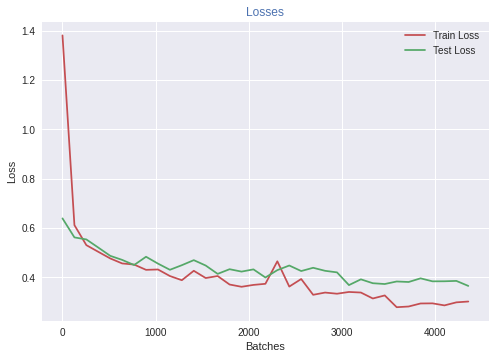

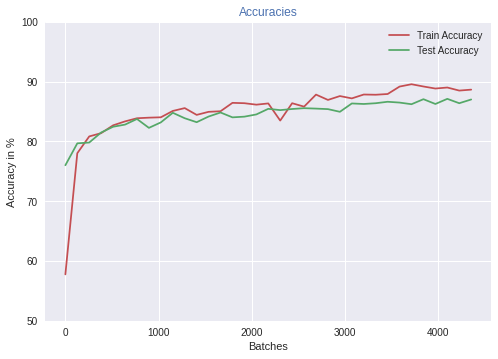

In [0]:
num_batches = np.arange(len(losses)) * PRINT_EVERY

mpl.style.use('seaborn')
fig, ax = plt.subplots()
ax.set_title('Losses', color='C0')
ax.plot(num_batches, losses, 'C2', label = "Train Loss" )
ax.plot(num_batches, t_losses, 'C1', label = "Test Loss")
plt.xlabel("Batches")
plt.ylabel("Loss")
ax.legend()

fig, bx = plt.subplots()
bx.set_title('Accuracies', color='C0')
bx.plot(num_batches, accuracies, 'C2', label = "Train Accuracy" )
bx.plot(num_batches, t_accuracies, 'C1', label = "Test Accuracy")
plt.ylim(50, 100)  
plt.xlabel("Batches")
plt.ylabel("Accuracy in %")
bx.legend()

### Learning rate too low

In [0]:
net = ConvNet(3, 3, 8, 8, 100)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.0001, momentum = 0.9)
init_params = initParams(method = torch.nn.init.kaiming_uniform_)
net.apply(init_params)

train_dataloader_ = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers = 2)
test_dataloader_  = torch.utils.data.DataLoader(test_dataset, batch_size = 256, shuffle = False, num_workers = 2)

losses = []
accuracies = []
t_losses = []
t_accuracies = []

for epoch in range(EPOCHS):
    
    running_loss = 0.0
    running_accuracy = 0.0
    for i, data in enumerate(train_dataloader_):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += accuracy(outputs, labels)
        PRINT_EVERY = 128
        if i % PRINT_EVERY == PRINT_EVERY - 1:    
            print('[EPOCH: %d, BATCH: %5d]\t Loss: %.3f\t Accuracy: %.3f %% ' %
                  (epoch + 1, i + 1, running_loss / PRINT_EVERY, running_accuracy*100 / PRINT_EVERY))
            
            t_loss, t_acc = test(net, test_dataloader_, criterion, accuracy)
            print("Test Loss: %f\t Test Accuracy: %f %%" %(t_loss, t_acc*100))

            losses.append(running_loss / PRINT_EVERY)
            accuracies.append(running_accuracy*100 / PRINT_EVERY)
            t_losses.append(t_loss)
            t_accuracies.append(t_acc*100)
            running_accuracy = 0.0
            running_loss = 0.0


[EPOCH: 1, BATCH:   128]	 Loss: 1.304	 Accuracy: 55.273 % 
Test Loss: 0.837683	 Test Accuracy: 70.185547 %
[EPOCH: 1, BATCH:   256]	 Loss: 0.758	 Accuracy: 72.595 % 
Test Loss: 0.705701	 Test Accuracy: 74.599609 %
[EPOCH: 1, BATCH:   384]	 Loss: 0.664	 Accuracy: 76.196 % 
Test Loss: 0.661743	 Test Accuracy: 75.976562 %
[EPOCH: 1, BATCH:   512]	 Loss: 0.624	 Accuracy: 77.222 % 
Test Loss: 0.630672	 Test Accuracy: 76.552734 %
[EPOCH: 1, BATCH:   640]	 Loss: 0.598	 Accuracy: 78.162 % 
Test Loss: 0.607445	 Test Accuracy: 77.558594 %
[EPOCH: 1, BATCH:   768]	 Loss: 0.582	 Accuracy: 79.053 % 
Test Loss: 0.584407	 Test Accuracy: 78.642578 %
[EPOCH: 1, BATCH:   896]	 Loss: 0.556	 Accuracy: 79.785 % 
Test Loss: 0.568475	 Test Accuracy: 79.267578 %
[EPOCH: 2, BATCH:   128]	 Loss: 0.543	 Accuracy: 80.005 % 
Test Loss: 0.571086	 Test Accuracy: 78.837891 %
[EPOCH: 2, BATCH:   256]	 Loss: 0.542	 Accuracy: 79.944 % 
Test Loss: 0.569217	 Test Accuracy: 78.613281 %
[EPOCH: 2, BATCH:   384]	 Loss: 0.537

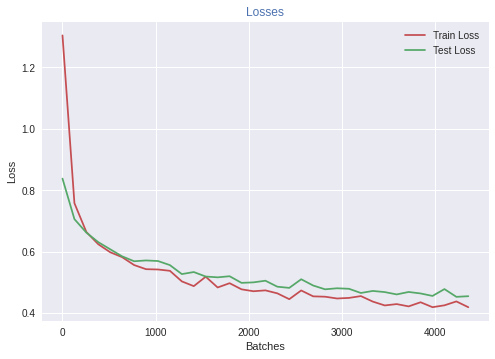

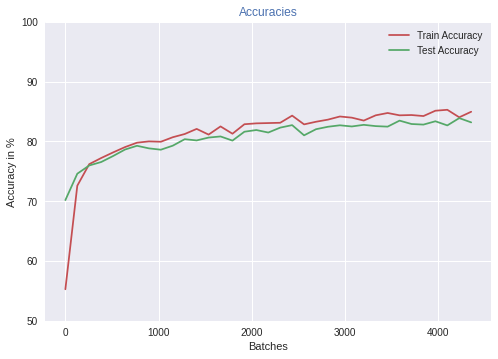

In [0]:
num_batches = np.arange(len(losses)) * PRINT_EVERY

mpl.style.use('seaborn')
fig, ax = plt.subplots()
ax.set_title('Losses', color='C0')
ax.plot(num_batches, losses, 'C2', label = "Train Loss" )
ax.plot(num_batches, t_losses, 'C1', label = "Test Loss")
plt.xlabel("Batches")
plt.ylabel("Loss")
ax.legend()

fig, bx = plt.subplots()
bx.set_title('Accuracies', color='C0')
bx.plot(num_batches, accuracies, 'C2', label = "Train Accuracy" )
bx.plot(num_batches, t_accuracies, 'C1', label = "Test Accuracy")
plt.ylim(50, 100)  
plt.xlabel("Batches")
plt.ylabel("Accuracy in %")
bx.legend()

#### Momentum too high

In [0]:
net = ConvNet(3, 3, 8, 8, 100)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.99)
init_params = initParams(method = torch.nn.init.kaiming_uniform_)
net.apply(init_params)

train_dataloader_ = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers = 2)
test_dataloader_  = torch.utils.data.DataLoader(test_dataset, batch_size = 256, shuffle = False, num_workers = 2)

losses = []
accuracies = []
t_losses = []
t_accuracies = []

for epoch in range(EPOCHS):
    
    running_loss = 0.0
    running_accuracy = 0.0
    for i, data in enumerate(train_dataloader_):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += accuracy(outputs, labels)
        PRINT_EVERY = 128
        if i % PRINT_EVERY == PRINT_EVERY - 1:    
            print('[EPOCH: %d, BATCH: %5d]\t Loss: %.3f\t Accuracy: %.3f %% ' %
                  (epoch + 1, i + 1, running_loss / PRINT_EVERY, running_accuracy*100 / PRINT_EVERY))
            
            t_loss, t_acc = test(net, test_dataloader_, criterion, accuracy)
            print("Test Loss: %f\t Test Accuracy: %f %%" %(t_loss, t_acc*100))

            losses.append(running_loss / PRINT_EVERY)
            accuracies.append(running_accuracy*100 / PRINT_EVERY)
            t_losses.append(t_loss)
            t_accuracies.append(t_acc*100)
            running_accuracy = 0.0
            running_loss = 0.0


[EPOCH: 1, BATCH:   128]	 Loss: 0.824	 Accuracy: 71.130 % 
Test Loss: 0.585219	 Test Accuracy: 78.623047 %
[EPOCH: 1, BATCH:   256]	 Loss: 0.634	 Accuracy: 78.101 % 
Test Loss: 0.697944	 Test Accuracy: 75.664062 %
[EPOCH: 1, BATCH:   384]	 Loss: 0.634	 Accuracy: 77.625 % 
Test Loss: 0.590287	 Test Accuracy: 78.681641 %
[EPOCH: 1, BATCH:   512]	 Loss: 0.569	 Accuracy: 80.054 % 
Test Loss: 0.531765	 Test Accuracy: 81.318359 %
[EPOCH: 1, BATCH:   640]	 Loss: 0.527	 Accuracy: 81.384 % 
Test Loss: 0.572113	 Test Accuracy: 80.087891 %
[EPOCH: 1, BATCH:   768]	 Loss: 0.530	 Accuracy: 81.543 % 
Test Loss: 0.496442	 Test Accuracy: 81.855469 %
[EPOCH: 1, BATCH:   896]	 Loss: 0.496	 Accuracy: 82.556 % 
Test Loss: 0.498519	 Test Accuracy: 82.011719 %
[EPOCH: 2, BATCH:   128]	 Loss: 0.434	 Accuracy: 84.631 % 
Test Loss: 0.459831	 Test Accuracy: 84.238281 %
[EPOCH: 2, BATCH:   256]	 Loss: 0.446	 Accuracy: 83.899 % 
Test Loss: 0.483356	 Test Accuracy: 82.871094 %
[EPOCH: 2, BATCH:   384]	 Loss: 0.426

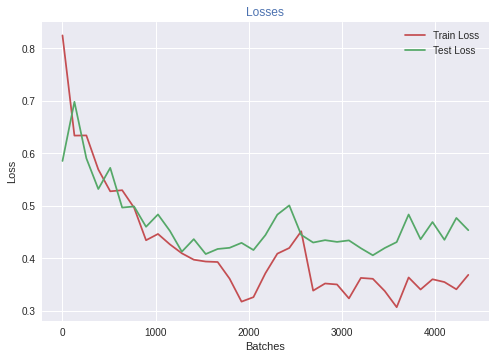

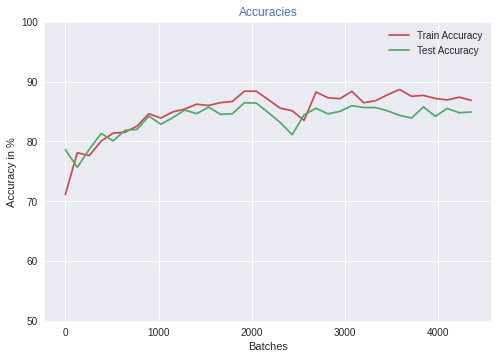

In [0]:
num_batches = np.arange(len(losses)) * PRINT_EVERY

mpl.style.use('seaborn')
fig, ax = plt.subplots()
ax.set_title('Losses', color='C0')
ax.plot(num_batches, losses, 'C2', label = "Train Loss" )
ax.plot(num_batches, t_losses, 'C1', label = "Test Loss")
plt.xlabel("Batches")
plt.ylabel("Loss")
ax.legend()

fig, bx = plt.subplots()
bx.set_title('Accuracies', color='C0')
bx.plot(num_batches, accuracies, 'C2', label = "Train Accuracy" )
bx.plot(num_batches, t_accuracies, 'C1', label = "Test Accuracy")
plt.ylim(50, 100)  
plt.xlabel("Batches")
plt.ylabel("Accuracy in %")
bx.legend()

### Batchsize too small

In [0]:
net = ConvNet(3, 3, 8, 8, 100)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9)
init_params = initParams(method = torch.nn.init.kaiming_uniform_)
net.apply(init_params)

train_dataloader_ = torch.utils.data.DataLoader(train_dataset, batch_size = 4, shuffle = True, num_workers = 2)
test_dataloader_  = torch.utils.data.DataLoader(test_dataset, batch_size = 256, shuffle = False, num_workers = 2)

losses = []
accuracies = []
t_losses = []
t_accuracies = []

for epoch in range(EPOCHS):
    
    running_loss = 0.0
    running_accuracy = 0.0
    for i, data in enumerate(train_dataloader_):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += accuracy(outputs, labels)
        PRINT_EVERY = 128
        if i % PRINT_EVERY == PRINT_EVERY - 1:    
            print('[EPOCH: %d, BATCH: %5d]\t Loss: %.3f\t Accuracy: %.3f %% ' %
                  (epoch + 1, i + 1, running_loss / PRINT_EVERY, running_accuracy*100 / PRINT_EVERY))
            
            t_loss, t_acc = test(net, test_dataloader_, criterion, accuracy)
            print("Test Loss: %f\t Test Accuracy: %f %%" %(t_loss, t_acc*100))

            losses.append(running_loss / PRINT_EVERY)
            accuracies.append(running_accuracy*100 / PRINT_EVERY)
            t_losses.append(t_loss)
            t_accuracies.append(t_acc*100)
            running_accuracy = 0.0
            running_loss = 0.0


[EPOCH: 1, BATCH:   128]	 Loss: 1.470	 Accuracy: 48.828 % 
Test Loss: 1.330503	 Test Accuracy: 48.945312 %
[EPOCH: 1, BATCH:   256]	 Loss: 1.187	 Accuracy: 59.766 % 
Test Loss: 1.210418	 Test Accuracy: 66.494141 %
[EPOCH: 1, BATCH:   384]	 Loss: 0.998	 Accuracy: 66.406 % 
Test Loss: 0.992358	 Test Accuracy: 70.771484 %
[EPOCH: 1, BATCH:   512]	 Loss: 0.937	 Accuracy: 67.773 % 
Test Loss: 0.784587	 Test Accuracy: 72.167969 %
[EPOCH: 1, BATCH:   640]	 Loss: 0.810	 Accuracy: 72.656 % 
Test Loss: 0.788717	 Test Accuracy: 71.503906 %
[EPOCH: 1, BATCH:   768]	 Loss: 0.795	 Accuracy: 72.852 % 
Test Loss: 0.738629	 Test Accuracy: 74.062500 %
[EPOCH: 1, BATCH:   896]	 Loss: 0.731	 Accuracy: 72.266 % 
Test Loss: 0.651498	 Test Accuracy: 76.972656 %
[EPOCH: 1, BATCH:  1024]	 Loss: 0.632	 Accuracy: 78.125 % 
Test Loss: 0.700938	 Test Accuracy: 75.039062 %
[EPOCH: 1, BATCH:  1152]	 Loss: 0.650	 Accuracy: 76.758 % 
Test Loss: 0.686906	 Test Accuracy: 75.791016 %
[EPOCH: 1, BATCH:  1280]	 Loss: 0.669

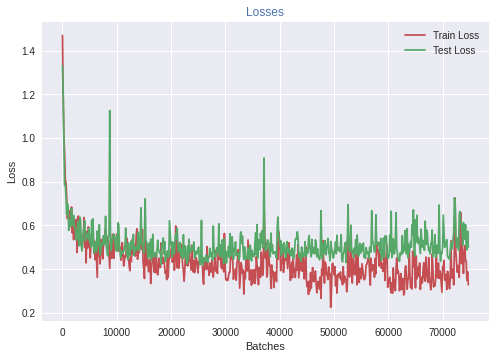

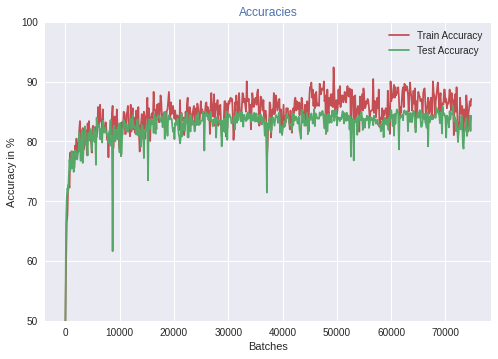

In [0]:
num_batches = np.arange(len(losses)) * PRINT_EVERY

mpl.style.use('seaborn')
fig, ax = plt.subplots()
ax.set_title('Losses', color='C0')
ax.plot(num_batches, losses, 'C2', label = "Train Loss" )
ax.plot(num_batches, t_losses, 'C1', label = "Test Loss")
plt.xlabel("Batches")
plt.ylabel("Loss")
ax.legend()

fig, bx = plt.subplots()
bx.set_title('Accuracies', color='C0')
bx.plot(num_batches, accuracies, 'C2', label = "Train Accuracy" )
bx.plot(num_batches, t_accuracies, 'C1', label = "Test Accuracy")
plt.ylim(50, 100)  
plt.xlabel("Batches")
plt.ylabel("Accuracy in %")
bx.legend()

### Overfitting due to large model

In [0]:
net = ConvNet(5, 5, 64, 64, 100)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9)
init_params = initParams(method = torch.nn.init.kaiming_uniform_)
net.apply(init_params)

train_dataloader_ = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers = 2)
test_dataloader_  = torch.utils.data.DataLoader(test_dataset, batch_size = 256, shuffle = False, num_workers = 2)

losses = []
accuracies = []
t_losses = []
t_accuracies = []

for epoch in range(20):
    
    running_loss = 0.0
    running_accuracy = 0.0
    for i, data in enumerate(train_dataloader_):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += accuracy(outputs, labels)
        PRINT_EVERY = 128

        if i % PRINT_EVERY == PRINT_EVERY - 1:    
            print('[EPOCH: %d, BATCH: %5d]\t Loss: %.3f\t Accuracy: %.3f %% ' %
                  (epoch + 1, i + 1, running_loss / PRINT_EVERY, running_accuracy*100 / PRINT_EVERY))
            
            t_loss, t_acc = test(net, test_dataloader_, criterion, accuracy)
            print("Test Loss: %f\t Test Accuracy: %f %%" %(t_loss, t_acc*100))

            losses.append(running_loss / PRINT_EVERY)
            accuracies.append(running_accuracy*100 / PRINT_EVERY)
            t_losses.append(t_loss)
            t_accuracies.append(t_acc*100)
            running_accuracy = 0.0
            running_loss = 0.0


[EPOCH: 1, BATCH:   128]	 Loss: 0.823	 Accuracy: 70.947 % 
Test Loss: 0.559600	 Test Accuracy: 79.375000 %
[EPOCH: 1, BATCH:   256]	 Loss: 0.519	 Accuracy: 81.030 % 
Test Loss: 0.466750	 Test Accuracy: 83.222656 %
[EPOCH: 1, BATCH:   384]	 Loss: 0.450	 Accuracy: 83.496 % 
Test Loss: 0.459341	 Test Accuracy: 83.017578 %
[EPOCH: 1, BATCH:   512]	 Loss: 0.402	 Accuracy: 85.620 % 
Test Loss: 0.449363	 Test Accuracy: 83.095703 %
[EPOCH: 1, BATCH:   640]	 Loss: 0.414	 Accuracy: 84.839 % 
Test Loss: 0.409606	 Test Accuracy: 85.029297 %
[EPOCH: 1, BATCH:   768]	 Loss: 0.403	 Accuracy: 85.107 % 
Test Loss: 0.407852	 Test Accuracy: 85.292969 %
[EPOCH: 1, BATCH:   896]	 Loss: 0.366	 Accuracy: 86.670 % 
Test Loss: 0.395367	 Test Accuracy: 85.878906 %
[EPOCH: 1, BATCH:  1024]	 Loss: 0.366	 Accuracy: 86.060 % 
Test Loss: 0.353036	 Test Accuracy: 87.402344 %
[EPOCH: 1, BATCH:  1152]	 Loss: 0.366	 Accuracy: 86.084 % 
Test Loss: 0.407507	 Test Accuracy: 84.980469 %
[EPOCH: 1, BATCH:  1280]	 Loss: 0.347

KeyboardInterrupt: ignored

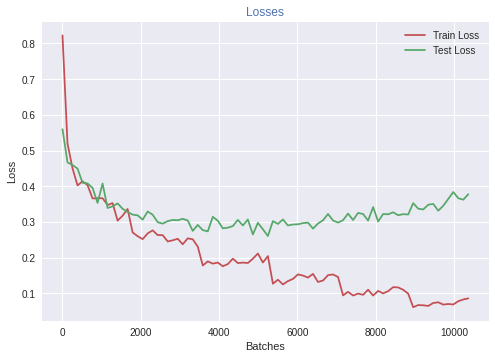

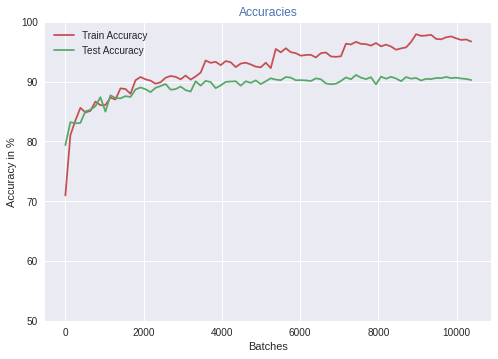

In [0]:
num_batches = np.arange(len(losses)) * PRINT_EVERY

mpl.style.use('seaborn')
fig, ax = plt.subplots()
ax.set_title('Losses', color='C0')
ax.plot(num_batches, losses, 'C2', label = "Train Loss" )
ax.plot(num_batches, t_losses, 'C1', label = "Test Loss")
plt.xlabel("Batches")
plt.ylabel("Loss")
ax.legend()

fig, bx = plt.subplots()
bx.set_title('Accuracies', color='C0')
bx.plot(num_batches, accuracies, 'C2', label = "Train Accuracy" )
bx.plot(num_batches, t_accuracies, 'C1', label = "Test Accuracy")
plt.ylim(50, 100)  
plt.xlabel("Batches")
plt.ylabel("Accuracy in %")
bx.legend()